In [ ]:
library(ggplot2)
library(dplyr)

In [ ]:
allsubmissions <- read.csv("../results/data/ALL_SubmissionsEnrichedExpanded.csv")
uniquesubmissions <- read.csv("../results/data/ALL_UniqueComplaintsEnrichedExpanded.csv")
boppop <- read.csv("../data/BOPPopulation.csv")


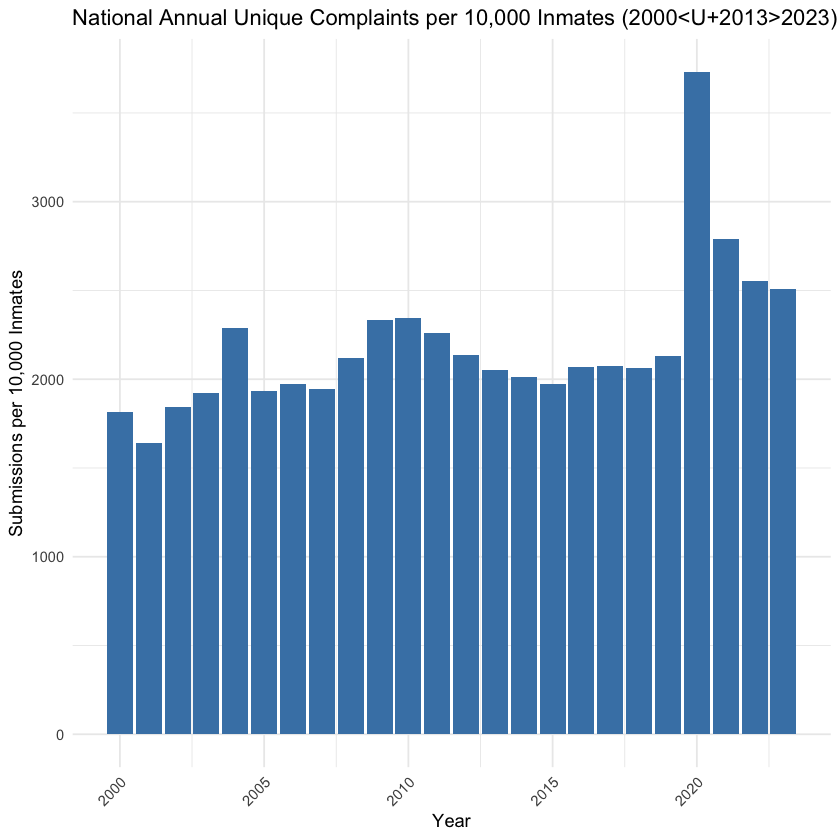

In [ ]:
# STEP 1: Make a visualization that uses the national BOP population to show how many unique complaints were made nationally per 10,000 inmates each year from 2000-2023

# Ensure the 'Remedy Case Submission date received' column is in Date format
uniquesubmissions <- uniquesubmissions %>%
  mutate(Remedy.Case.Submission.date.received = as.Date(Remedy.Case.Submission.date.received, format = "%Y-%m-%d"))

# Extract the year from the submission date
uniquesubmissions <- uniquesubmissions %>%
  mutate(Year = as.numeric(format(Remedy.Case.Submission.date.received, "%Y")))

# Count the number of unique submissions per year
submissions_per_year <- uniquesubmissions %>%
  filter(Year >= 2000 & Year <= 2023) %>%
  group_by(Year) %>%
  summarize(Unique_Submissions = n(), .groups = "drop")

# Merge with BOP population data
submissions_vs_population <- merge(submissions_per_year, boppop, by.x = "Year", by.y = "year")

# Fix the BOP_population column by removing commas and converting to numeric
submissions_vs_population <- submissions_vs_population %>%
  mutate(
    BOP_population = as.numeric(gsub(",", "", BOP_population))
  )

# Calculate submissions per 10,000 inmates
submissions_vs_population <- submissions_vs_population %>%
  mutate(Submissions_per_10k = (Unique_Submissions / BOP_population) * 10000)

# Visualization: Submissions per year normalized by population
ggplot(submissions_vs_population, aes(x = Year, y = Submissions_per_10k)) +
  geom_bar(stat = "identity", fill = "steelblue") +
  labs(
    title = "National Annual Unique Complaints per 10,000 Inmates (2000–2023)",
    x = "Year",
    y = "Submissions per 10,000 Inmates"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# Save the plot
ggsave(
  filename = "../results/analysis/ALL_UniqueComplaintsPer10kInmates.png",
  width = 14,
  height = 8,
  units = "in"
)


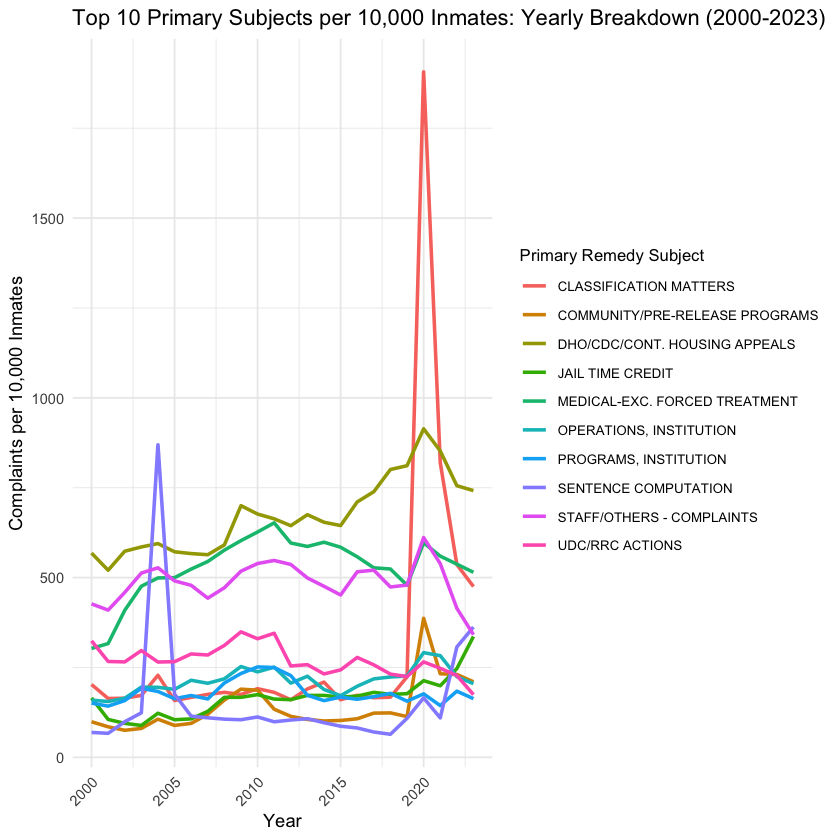

In [ ]:
# STEP 2: Create a visualization that finds the top 10 Primary Subjects from 2000-2024 and shows a breakdown of the number of unique complaints made per 10,000 inmates (based on BOP pop data) each year.

# Ensure 'Remedy Case Submission date received' is in Date format
allsubmissions <- allsubmissions %>%
  mutate(Remedy.Case.Submission.date.received = as.Date(Remedy.Case.Submission.date.received, format = "%Y-%m-%d"))

# Extract the year from the submission date as a numeric type
allsubmissions <- allsubmissions %>%
  mutate(Year = as.numeric(format(Remedy.Case.Submission.date.received, "%Y")))

# Find the top 10 complaints by primary code
top_complaints <- allsubmissions %>%
  count(Primary.Remedy.Subject, sort = TRUE) %>%
  slice_head(n = 10) %>%
  pull(Primary.Remedy.Subject)

# Filter the dataset for only top complaints
top_complaints_data <- allsubmissions %>%
  filter(Primary.Remedy.Subject %in% top_complaints)

# Summarize complaints per year and normalize per 10,000 BOP population
complaints_by_year <- top_complaints_data %>%
  group_by(Year, Primary.Remedy.Subject) %>%
  summarize(Complaint_Count = n(), .groups = "drop") %>%
  left_join(boppop, by = c("Year" = "year")) %>%
  mutate(
    BOP_population = as.numeric(gsub(",", "", BOP_population)),  # Remove commas and convert to numeric
    Complaints_per_10k = (Complaint_Count / BOP_population) * 10000
  )

# Exclude 2024 and any missing data
complaints_by_year <- complaints_by_year %>%
  filter(Year < 2024 & !is.na(Complaints_per_10k))

# Create the line graph
top_complaints_plot <- ggplot(complaints_by_year, aes(x = Year, y = Complaints_per_10k, color = `Primary.Remedy.Subject`, group = `Primary.Remedy.Subject`)) +
  geom_line(linewidth = 1) +
  labs(
    title = "Top 10 Primary Subjects per 10,000 Inmates: Yearly Breakdown (2000-2023)",
    x = "Year",
    y = "Complaints per 10,000 Inmates",
    color = "Primary Remedy Subject"
  ) +
  theme_minimal() +
  theme(
    legend.position = "right",
    legend.title = element_text(size = 10),
    legend.text = element_text(size = 8),
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

# Save the plot
ggsave(
  filename = "../results/analysis/ALL_PrimarySubjectsYearlyBreakdownPer10kInmates.png",
  plot = top_complaints_plot,
  width = 14,
  height = 8,
  units = "in"
)

# Print the plot
print(top_complaints_plot)
